### AST 5731 
#### Group 1 - Project 1
#### Group Members: Ana Uribe, Darya Biparva, Tyler Barna, Alex Granados

 ##### Contents
 1.   [Introduction](#introduction)
 2.   [Data](#data)  
    2.1 [Importing Data](#importing-data)    
   2.2 [Data Processing](#processing)  
   2.3 [Data Visualization](#visualization)
 3.   [Analysis](#analysis)   
    3.1 [Components of Statistical Model](#model)  
    3.2 [Prior Predictive Check](#prior)     
    3.3 [Posterior](#posterior)     
    3.4 [Sensitivity Analysis](#senstivity)
 4.   [Results](#results)

### 1. Introduction 
<a id='introduction'></a>

In this analysis, we are interested in determining the radius of exoplanet TOI-564 b. 

This exoplanet was detected using the transit method, meaning that the planet was observed passing in front of it's star, causing a small decrease in the brightness of the star. This is represented by a dip in the light curve. 

The dip, or transit depth, is related to the radius of the exoplanet by the following equation:
$$\displaystyle \Delta F_{rel} = \frac{R_p^2}{R_s^2}$$
where $\Delta F_{rel}$ is the relative change in flux of the light curve, $R_p$ is the radius of the planet, and $R_s$ is the radius of the star.

In our solar system, Jupiter's radius, $R_j = 0.01 R_{sun}$ so we expect to see a 1% dip in brightness or a transit depth of 100 parts per million (ppm).

For TOI-564b, $R_s=1.04(\pm 0.05)R_{sun}$

TOI-564b was observed by the Transiting Exoplanet Survey Satellite (TESS) in multiple sectors, but our analysis is focused on Sector 34 data. With an observation time of approximately 28 days and a orbital period of 1.65 days, there are 14 transit depths. 

The repeated measurements of the transit depth should create a normal distribution. Thus our statistical question is as follows:

What is the mean of the distribution of the depth of exoplanet TOI-564 b's transit? 

We will perform a Bayesian analysis to answer this question, and then use the mean transit depth to find the radius of exoplanet TOI-564 b.

### 2. Data
<a id='data'></a>

TESS is a space satellite with a mission to survey the sky and detect exoplanets via the transit method. To do this, it separates the sky into 26 different sectors and observes each sector for approximately 26 days. It takes 2 second exposures every 30 mins for 14 consecutive days, then takes a 2-3 day break to send the data back to Earth before going back to observe the same sector for another 14 consecutive days.

All the public TESS data is on MAST (the Mikulski Archive for Space Telescopes), where we retrieved the lightcurve data for TOI-564b.

Note: Our project was run on python 3.9.13, and an environment package detailing the versions for all packages used can be found [here](https://github.com/tylerbarna/AST5731-projects/blob/main/environment.yml).

Importing packages used for project:

In [1]:
import csv
import dis
import inspect
import os
import sys
import time


import astropy
import astroquery
import lightkurve as lk ## for importing and manipulating TESS data
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import scipy as sp
import scipy.stats as stats
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

from astropy import units as u
from astropy import constants as const
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.time import TimeDelta
from astropy.timeseries import TimeSeries
from astropy.visualization import time_support
time_support()
from astropy.visualization import quantity_support
quantity_support()

from lightkurve import search_targetpixelfile

from numpy import interp

from sklearn import preprocessing as pp

from scipy import linalg as la
from scipy import optimize
from scipy import integrate

from scipy.stats import norm
from scipy.stats import beta
from scipy.stats import binom

from IPython.display import display_html
from IPython.display import Image

%matplotlib inline

## set seed for reproducibility
random.seed(5731)

#### 2.1 Importing Data
<a id='importing'></a>  

While it is possible to search for and import data directly from an online database using the lightkurve package, we found this unprocessed data to be more difficult to work with, as the lighkurve method does not filter data particularly well. Instead, we opted to use data from MAST, which was processed by the TESS Science Office to reduce outliers caused by instrumental effects and the orbit of TESS. 

In [2]:
## read in data using astropy.io.fits 
fits_file = fits.open('./data/lc.fits')
fits_file.info()
print()

## read in the light curve data as a pandas dataframe
df = pd.DataFrame(fits_file[1].data)
df.info()


Filename: ./data/lc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   ()      
  1  LIGHTCURVE    1 BinTableHDU    167   18231R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        49   (11, 11)   int32   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18231 entries, 0 to 18230
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TIME             17457 non-null  float64
 1   TIMECORR         18231 non-null  float32
 2   CADENCENO        18231 non-null  int32  
 3   SAP_FLUX         17411 non-null  float32
 4   SAP_FLUX_ERR     17411 non-null  float32
 5   SAP_BKG          17411 non-null  float32
 6   SAP_BKG_ERR      17411 non-null  float32
 7   PDCSAP_FLUX      16855 non-null  float32
 8   PDCSAP_FLUX_ERR  16855 non-null  float32
 9   QUALITY          18231 non-null  int32  
 10  PSF_CENTR1  

Now, let's plot the light curve!

In [3]:
## removes outlier at upper end
popOutlier = False
if popOutlier:
    df = df[(df['PDCSAP_FLUX'] <= 8590) | (np.isnan(df['PDCSAP_FLUX']))]

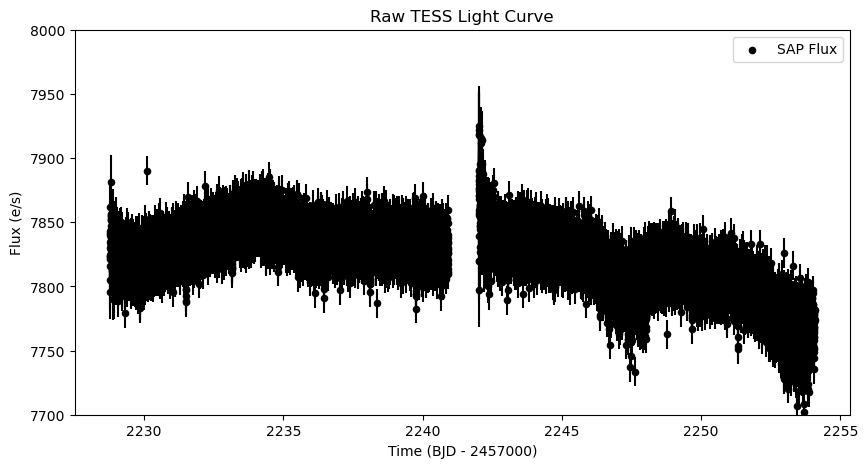

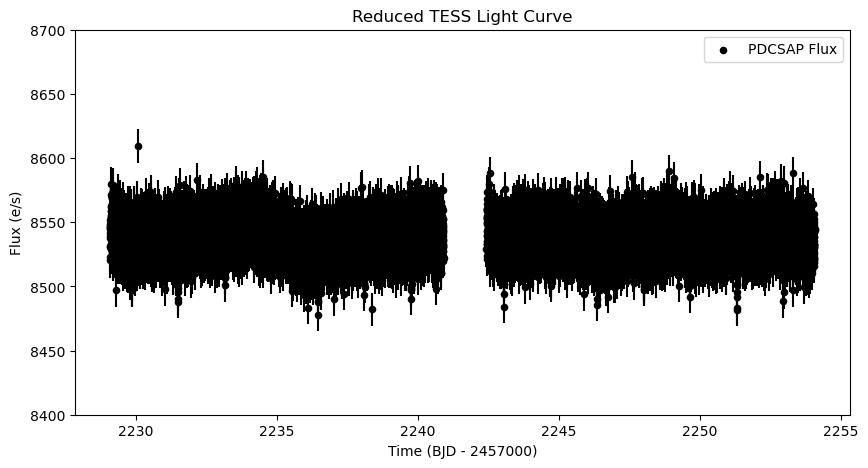

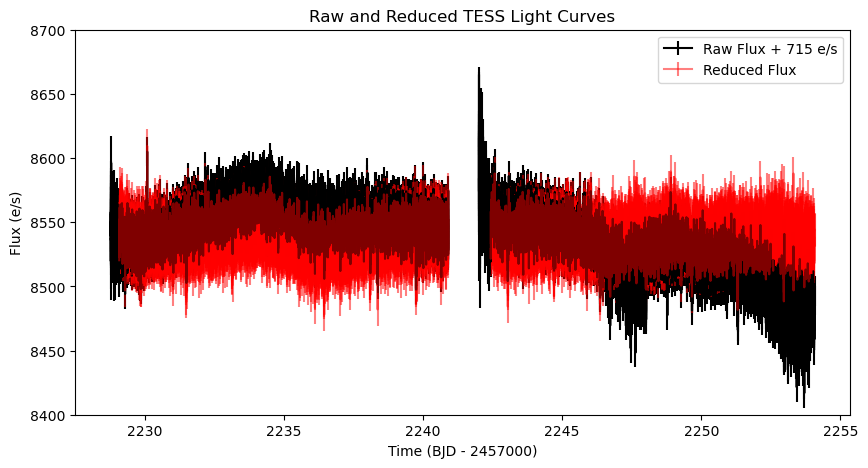

In [4]:
## plot raw flux data (sap_flux)
df.plot(x='TIME', y='SAP_FLUX', yerr='SAP_FLUX_ERR', figsize=(10,5), color='black', label='SAP Flux', kind='scatter', title='Raw TESS Light Curve')
plt.ylim(7700, 8000)
plt.xlabel('Time (BJD - 2457000)');
plt.ylabel('Flux (e/s)');
plt.show();

## plot the reduced data (pdcsap_flux)
df.plot(x='TIME', y='PDCSAP_FLUX', yerr='PDCSAP_FLUX_ERR', figsize=(10,5), color='black', label='PDCSAP Flux', kind='scatter', title='Reduced TESS Light Curve')
plt.ylim(8400, 8700)
#plt.ylim(0.9*df['SAP_FLUX'].min(), 1.1*df['SAP_FLUX'].max()) ## for consistency of comparison
plt.xlabel('Time (BJD - 2457000)');
plt.ylabel('Flux (e/s)');
plt.show();

## plot them together, adusting values so they are centered together
raw_mean = df['SAP_FLUX'].mean()
reduced_mean = df['PDCSAP_FLUX'].mean()
mean_diff = reduced_mean - raw_mean
raw_flux_adj = df['SAP_FLUX'] + mean_diff
reduced_flux_adj = df['PDCSAP_FLUX']
fig, ax = plt.subplots(figsize=(10,5))
ax.errorbar(df['TIME'], raw_flux_adj, yerr = df['SAP_FLUX_ERR'],color='black', label='Raw Flux + {} e/s'.format(round(mean_diff)))
ax.errorbar(df['TIME'], reduced_flux_adj, yerr=df['PDCSAP_FLUX_ERR'], color='red', label='Reduced Flux',alpha=0.5)
plt.ylim(8400, 8700)
plt.xlabel('Time (BJD - 2457000)');
plt.ylabel('Flux (e/s)');
plt.title('Raw and Reduced TESS Light Curves')
plt.legend();
plt.show();

The "SAP_FLUX" column represents the unreduced lightcurve data, whereas the the "PDCSAP_FLUX" column represents the reduced lightcurve data. We note that the reduced data has an average flux value of roughly 715 $e/s$ higher than the raw lightcurve. One can clearly see that this has significantly fewer outliers. This makes it easier to detect actual transits and the mean flux value will be more representative of the actual baseline. As a result, we will be using the reduced data for our analysis.

#### 2.2 Data Processing 
<a id='processing'></a>  

To make analysis easier, we will be normalizing the data. This means that the transit depth that we measure will be change in relative flux and can be directly plugged into the equation detailed in the introduction. This will be accomplished by using the equation
$$
\begin{equation}
norm(x) = \frac{x}{x_{median}}
\end{equation}
$$
where $x_{median}$ is the median flux value, and $norm(x)$ is the resulting normalized flux value. For the flux error, we determine the scale ratio for each flux point and then apply that same scaling to the corresponding error value. This ensures that the error values are scaled in the same way as the flux values.

Max Flux: 8609.421875 e/s
Mean Flux: 8537.895957709137 e/s
Min Flux: 8478.0234375 e/s

Normalized Flux Max: 1.0083643689252983
Normalized Flux Mean: 0.9999870135699709
Normalized Flux Min: 0.9929745431703073


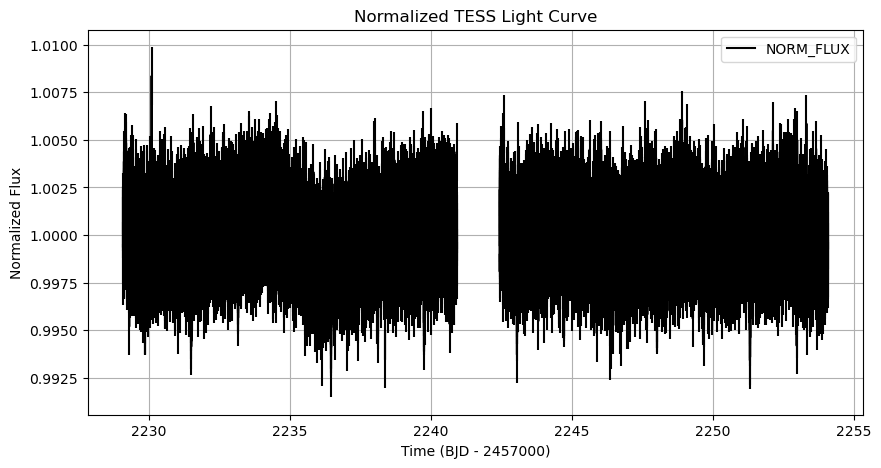

In [5]:
## retreive the flux data and flux error as numpy arrays to process

flux = df['PDCSAP_FLUX'].astype(float)
flux_err = df['PDCSAP_FLUX_ERR'].astype(float)

## find the max and min flux values
max_flux = np.max(flux)
min_flux = np.min(flux)
median_flux = np.nanmedian(flux)
mean_flux = np.mean(flux)


print('Max Flux: %s e/s'% max_flux)
print('Mean Flux: %s e/s'% np.nanmean(flux))
print('Min Flux: %s e/s'% min_flux)

## define normalization function
norm_factor = lambda x: np.nanmedian(x) ## modify this to change the method for normalization
# norm_x = lambda x: (x - np.min(x))/(norm_factor(x) - np.min(x))
norm_x = lambda x: (x)/(norm_factor(x))
norm_flux = norm_x(flux)
#norm_flux_err = norm(flux_err)

## normalize flux error by taking the ratio of the normalized flux to the original flux for each data point
norm_ratio = norm_flux/flux ## will be less than 1
norm_flux_err = norm_ratio*flux_err ## will be less than flux_err


## add normalized flux and flux error to the dataframe
df['NORM_FLUX'] = norm_flux
df['NORM_FLUX_ERR'] = norm_flux_err
norm_flux_mean = df['NORM_FLUX'].mean()

print()
print('Normalized Flux Max: %s'% np.max(norm_flux))
print('Normalized Flux Mean: %s'% norm_flux_mean)
print('Normalized Flux Min: %s'% np.min(norm_flux))


## plot the normalized flux data
ax = df.plot(x='TIME', y='NORM_FLUX', yerr='NORM_FLUX_ERR', figsize=(10,5), color='black',  title='Normalized TESS Light Curve',alpha=1)
plt.xlabel('Time (BJD - 2457000)');
plt.ylabel('Normalized Flux');  
ax.grid()
plt.show();

In order to find the transit depth of the 14 transits in the dataset, the transits were separated into individual light curves by manually identifying their rough start and end times. The transit time range can be seen in the dictionary `transit_times`.

The depth and exact time of the transit were then calculated based on the minimum flux and stored in the dataframe `tdf`. 
They are displayed on their respective plots. 

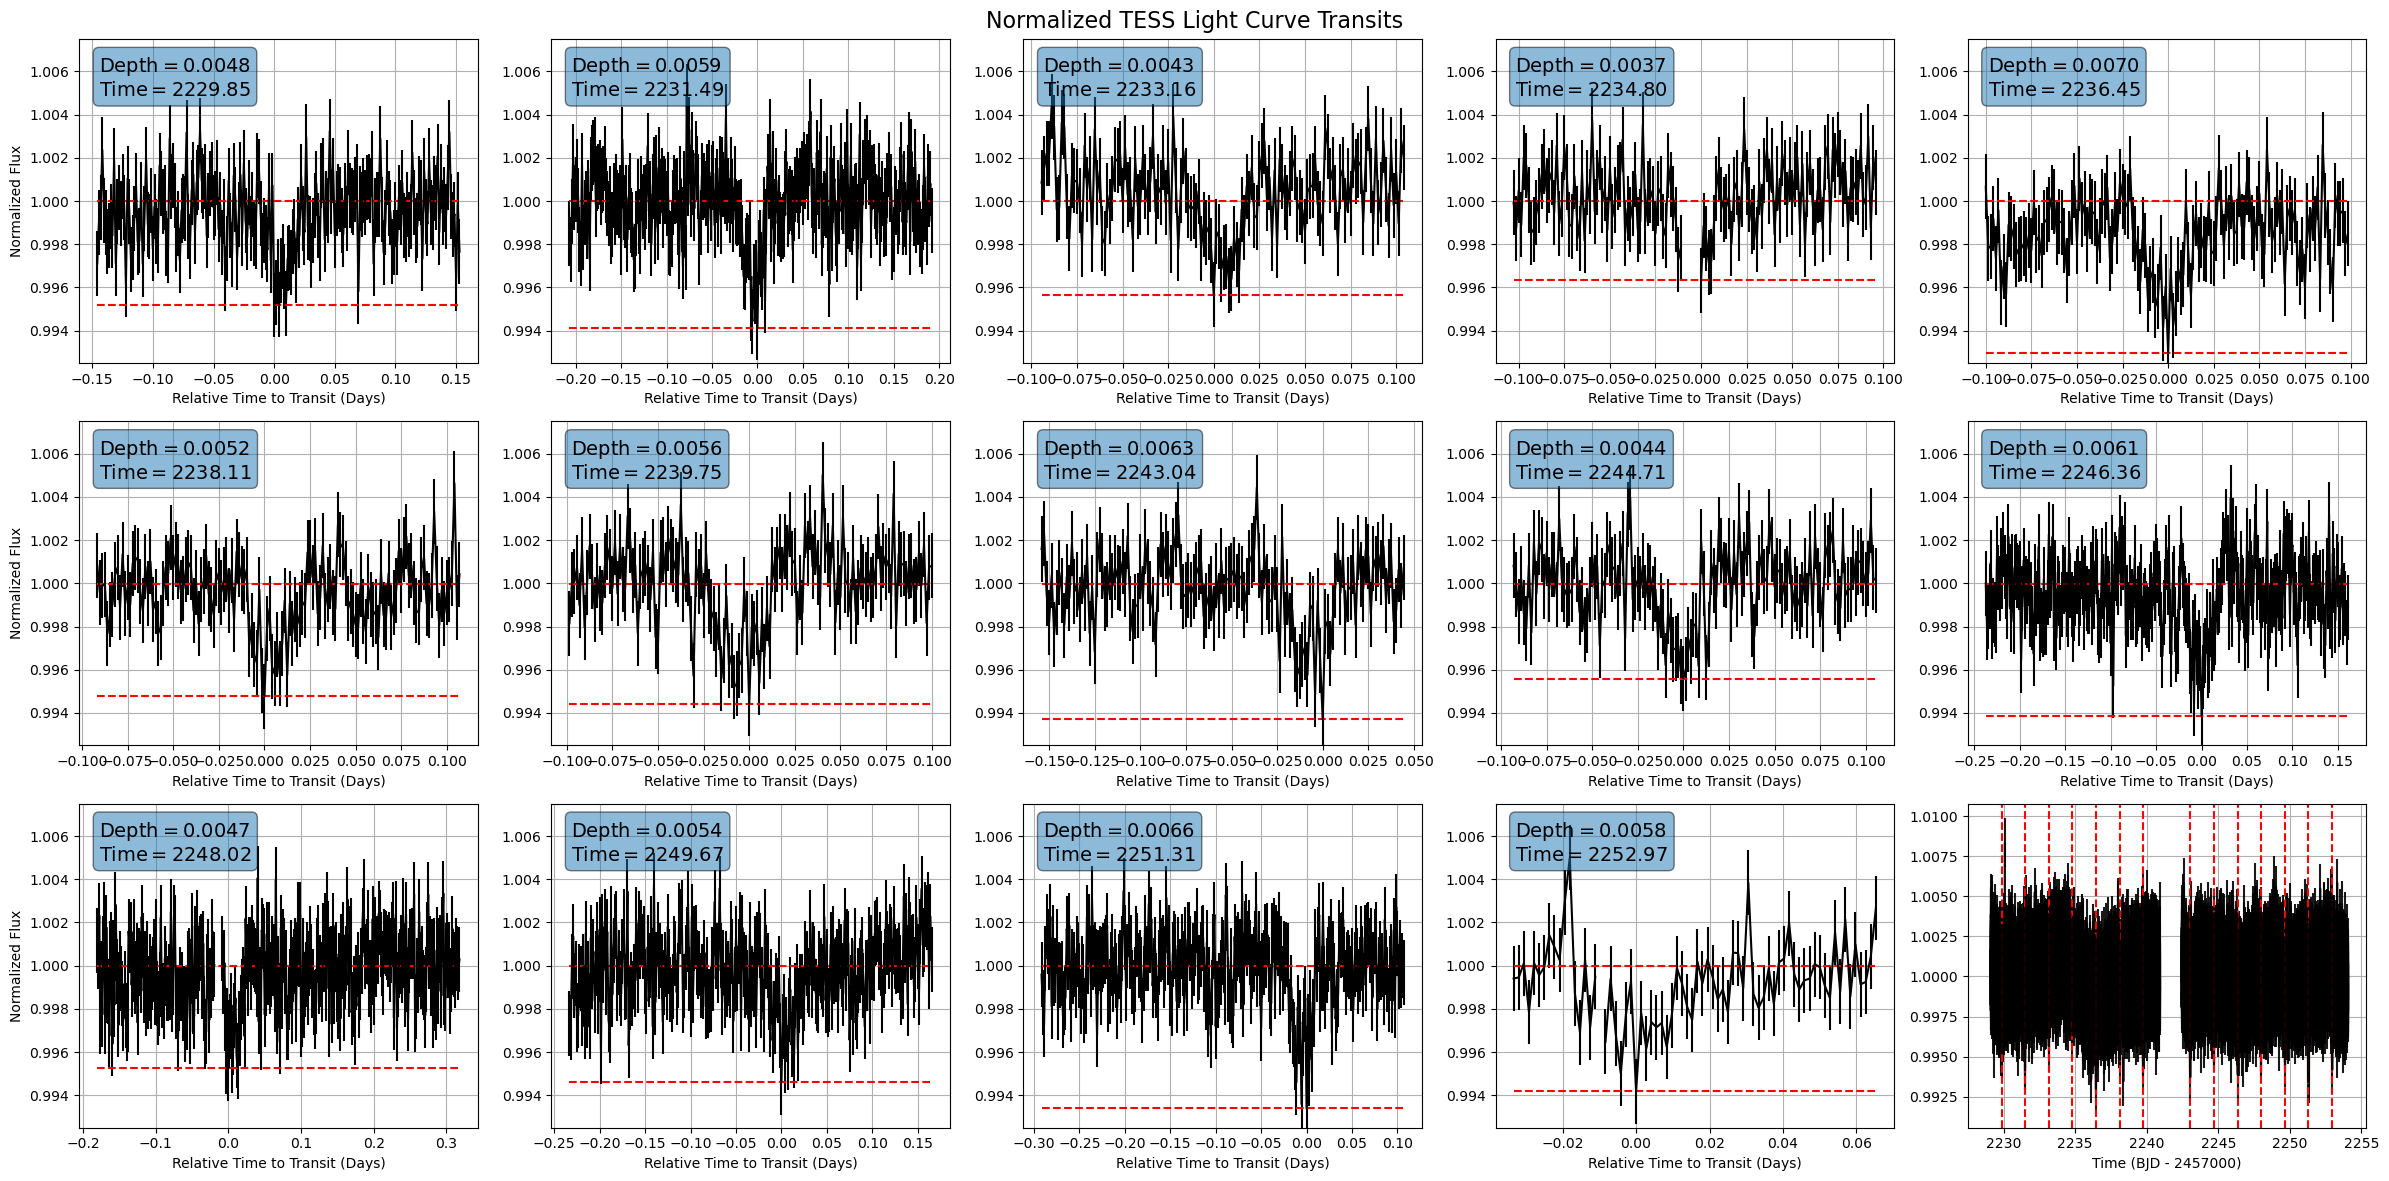

Data frame 'tdf':


,Transit,Time,Depth
0,t01,2229.853950,0.004801
1,t02,2231.492896,0.005854
2,t03,2233.155448,0.004335
3,t04,2234.797162,0.003658
4,t05,2236.449981,0.007012
5,t06,2238.106961,0.005218
6,t07,2239.750045,0.005567
7,t08,2243.044534,0.006277
8,t09,2244.705672,0.004391
9,t10,2246.361248,0.006118


In [6]:
## define function to seperate data into transits and plot them in subplots
transit_times = {
    't01': [2229.7, 2230],
    't02': [2231.3, 2231.7],
    't03': [2233.05, 2233.25],
    't04': [2234.7, 2234.9],
    't05': [2236.35, 2236.55],
    't06': [2238, 2238.2],
    't07': [2239.65, 2239.85],
    't08': [2243, 2243.2],
    't09': [2244.6, 2244.8],
    't10': [2246.2, 2246.6],
    't11': [2247.7, 2248.2],
    't12': [2249.5, 2249.9],
    't13': [2251.2, 2251.6],
    't14': [2252.9, 2253],
}

def transits(df, times, plot=True, save=False):
    '''
    Creates a dataframe of the time and depth of each transit and also plots them
    '''

    fig, axs = plt.subplots(3,5, figsize=(24, 12)) 
    fig.set_facecolor('white') 
    idx=0 ##counter for subplot index
    depths = {} ## dictionary to store transit depths
    times = {} ## dictionary to store the width of each transit
    for key, value in transit_times.items():
        
        transit = df[(df['TIME'] > value[0]) & (df['TIME'] < value[1])]
        min_flux = np.min(transit['NORM_FLUX'])
        depths[key] = norm_flux_mean - min_flux
        #times[key] = interp(min_flux, transit['NORM_FLUX'], transit['TIME'])
        times[key] = transit['TIME'][transit['NORM_FLUX'].idxmin()]

        if plot:
            ax = axs.flatten()[idx]
            relative_time = times[key] - transit['TIME']
            ax.errorbar(relative_time, transit['NORM_FLUX'], yerr=transit['NORM_FLUX_ERR'], color='black', label=key)
            #transit.plot(x=relative_time, y='NORM_FLUX', yerr='NORM_FLUX_ERR', ax=ax, color='black', label=key)
            ax.hlines(norm_flux_mean, relative_time.min(), relative_time.max(), color='r', linestyle='--', label='Mean Flux')
            ax.hlines(min_flux, relative_time.min(), relative_time.max(), color='r', linestyle='--', label='Transit Depth')
            ax.set_ylim(0.9925, 1.0075)
            ax.set_xlabel('Relative Time to Transit (Days)')
            ax.grid()

            textstr = '\n'.join((
                r'$\mathrm{Depth}=%.4f$' % (depths[key], ),
                r'$\mathrm{Time}=%.2f$' % (times[key], )))
            props = dict(boxstyle='round', alpha=0.5)
            ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
            
        idx+=1
    ## hide the empty subplot
    #axs.flatten()[14].set_visible(False)

    
    ## Alternate option: on the 14th subplot, plot the entire light curve with axv lines for each transit
    if plot:
        ax = axs.flatten()[14]
        ax.errorbar(df['TIME'], df['NORM_FLUX'], yerr=df['NORM_FLUX_ERR'], color='black', label='Normalized Flux',alpha=0.9)
        ax.set_xlabel('Time (BJD - 2457000)')
        ax.grid()
        #ax.hlines(norm_flux_mean, df['TIME'].min(), df['TIME'].max(), color='r', linestyle='--', label='Mean Flux')
        [ax.axvline(x=times[key], color='r', linestyle='--') for key in times.keys()]   
        for idx in (0,5,10):
            ax = axs.flatten()[idx]
            ax.set_ylabel('Normalized Flux')
        
        fig.suptitle('Normalized TESS Light Curve Transits', fontsize=16)
        plt.tight_layout()
        fig.save('transits.png') if save else None
        plt.show();
    ## combine dictionaries into one before converting into a dataframe
    tDict = {'Transit': list(times.keys()), 'Time': list(times.values()),'Depth': list(depths.values())}
    tdf = pd.DataFrame.from_dict(tDict)

    return tdf

tdf = transits(df=df, times=transit_times, plot=True, save=False)


print("Data frame 'tdf':")
display(tdf)


We plot the time between transits as a check for the times we calculated.

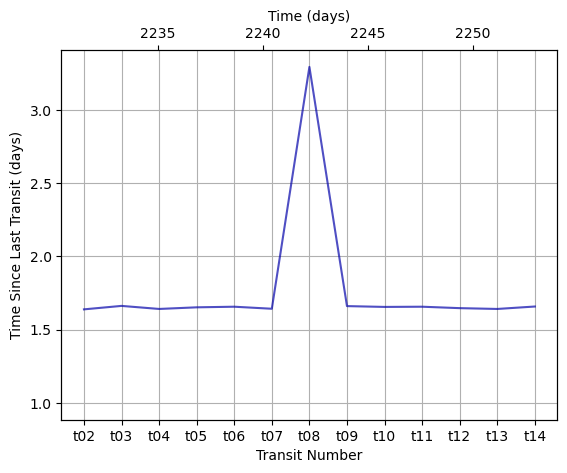

In [7]:
## plot time between transits
times = tdf['Time'].values
time_diff = np.diff(times)
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny() ## this is just so we can have a second x-axis, will be populated with a dummy plot
time_diff_scatter = ax1.plot(tdf['Transit'][1:], time_diff, color = '#0504aa', alpha = 0.7)
ax2.plot(tdf['Time'][1:],np.ones(len(tdf['Time'][1:])), color = 'white', alpha = 0.0)

ax1.set_xlabel('Transit Number')
ax1.set_ylabel('Time Since Last Transit (days)')
ax2.set_xlabel('Time (days)')
ax1.grid()
plt.show();

While the time between transit 7 and transit 8 seems to be roughly double the other values, this occurs at the time in TESS' orbit when it is unable to provide data, suggesting that there is a transit that occured during this gap. Otherwise, the time between transits is very consistent, so the times we calculated are reasonable.

#### 2.3 Data Visualization
<a id='visualization'></a>

Now that we have found our transit depths, we can visualize the data we will be working with.

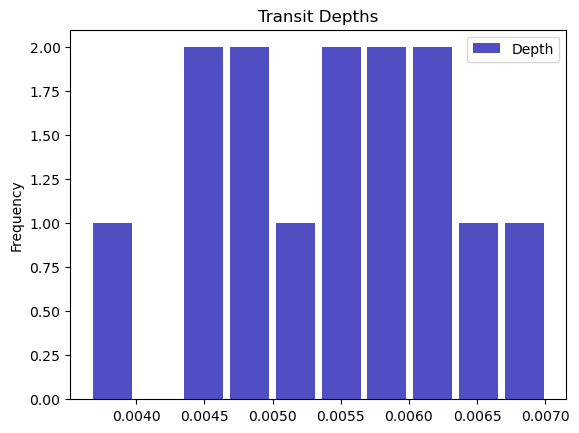

In [8]:
# plot transit depths: histogram
depths_hist = tdf.plot(y = 'Depth',
                          color = '#0504aa',
                          alpha = 0.7,
                          rwidth = 0.85,
                          title = 'Transit Depths',
                          kind = 'hist')
plt.show();

The histogram plot shows the frequency of each depth, and we see all the depth measurements are between 0.0035 and 0.007. 

Though this plot does not make the data look very normally distributed, we note that the frequencies vary by one, and our sample is not very big. Further, we do not see anything such as a large spread, or a split in the data that would make us question a normality assumption.

Thus, we will treat these repeated measures as normally distributed.

### 3. Bayesian Analysis
<a id='analysis'></a>

Recall our statistical question: What is the mean of the distribution of the depth of exoplanet TOI-564 b's transit?

To answer this, we will perform a Bayesian analysis on our data.
 

#### 3.1 Components of Statistical Model
<a id='model'></a>

  - **Parameters**: $\theta$ is the mean transit depth that we are trying to find in order to determine the radius of TOI-564 b
  - **Parameter Space**: $\Theta$ is any real number between 0 and 1. Because we normalized the data, the transit depths cannot be larger than 1 or less than 0
  - **Data Characteristics**: $x_i$ is the $i^{th}$ transit depth from the data where $i=1,2,...,n$ and $n=14$
  - **Sample Space**: the sample space is all possible vectors of 14 real-valued numbers between zero and one.
  - **Likelihood**: 

      From our data visualization and the fact we have repeated measures, we decide we can assume the repeated measures of TOI-564 b's transit depth are normally distrubuted and centered around the true mean of the transit depth. In effect, each measurement
      $$
      X_{i} \sim N(\theta, v) \text{ for } i = 1,...,14
      $$
      Where $\theta$ is the mean of the transit depth measurments and $v$ is the variance of the measurments. 
      Thus, our likelihood is
      $$
      p(x | \theta) \sim N(\theta, v) \text{ for } i = 1,...,14.
      $$
      We will choose $v$ to be the sample variance, and calculate it by squaring the mean of the measurement errors.
  - **Prior**:
  
      We are trying to estimate the mean of the transit depth using repeated measures, which means that the posterior distribution for $\theta$ should be normal. We will assume our prior is normally distrubuted to utilize the Normal-Normal conjugate set-up.
  
      That is, 
      $$  \nu(\theta) \sim N(a, b)  $$
      The mean must lie between zero and one due to our normalization of the data. We will choose our prior mean $a = 0.01$, and our prior variance to be $b$ = $\frac{1}{36}$.
   
      We choose $a = 0.01$ because exoplanet TOI-564 b is a hot Jupiter, and we expect it to have a depth of around one percent, i.e., a transit depth of $0.01$.
   
      We choose $b = \frac{1}{36}$ as a compromise between not placing our probabilities on negative values, which are not in our parameter space, and still having some variation that accounts for the range of hot Jupiter transit depths (1-5 percent).

Below are some functions we will use to calculate and plot the posterior probability, as well as the radius of the exoplanet.

In [9]:
### --------------------------------------- Functions ------------------------------------------------ ###

# posterior_prob: Function to calculate the posterior probability of a transit depth AND the corresponding radius
#
# Input: tdf - dataframe with transit depths
#        params - prior parameters a and b
#        verbose - Boolean that prints posterior mean, variance, and radius when set to True
# 
# Output: dict - dictionary with vaules:    theta_post - posterior mean
#                                           var_post - posterior variance
#                                           Rp - radius of exoplanet
#                                           varRp - variance of exoplanet radius
#         
def posterior_prob(tdf, params,verbose=True):
    '''
    Calculates the posterior probability of a transit depth
    '''
    ## define the parameters
    a, b = params
    v = (np.mean(df['NORM_FLUX_ERR'])**2)*2 #two points to get the transit depth so add error in quadrature to get the extra factor of 2 out front
    n = len(tdf['Transit'])
    xbar = np.mean(tdf['Depth'])
    
    theta_post = 1./(n/v+1/b)*(n*xbar/v)
    var_post = 1./(n/v+1/b)

    print(f'Posterior mean:{theta_post:.5f}') if verbose else None
    print(f'Posterior variance: {var_post:.9f}') if verbose else None

    #finding the radius (target is 1.02Rj)
    Rs = 1.04  #radius of the star in Rsun
    # print('Rs=', Rs)
    R_j = const.R_jup / const.R_sun #radius of Jupiter in Rsun
    # print('R_j=', R_j)
    R_s_jup = (Rs / R_j).value #Rjup/Rsun ## isn't it the other way around? ## radius of star in units of jupiter radii
    # print('R_s_jup=', R_s_jup)
    Rp = Rs*((theta_post)**0.5)*R_s_jup #Rjup
    print(f'Radius of TOI-564b: {Rp:.5f} Rjup') if verbose else None

    delRs = 0.05 #Rsun
    delRp = Rp*np.sqrt(((delRs/Rs)**2)+(0.5*np.sqrt(var_post)/theta_post)**2)
    varRp = delRp**2
    print(f'Radius variance: {varRp:.5f} Rjup') if verbose else None

    ## calculate the posterior probability
    x_post = np.linspace(norm.ppf(0.0001, loc=theta_post, scale=var_post**0.5), norm.ppf(0.99999, loc=theta_post, scale=var_post**0.5))
    y_post = norm.pdf(x_post, loc = theta_post, scale = var_post**0.5)
    dict = {'x': x_post, 'y': y_post, 'theta_post': theta_post, 'var_post': var_post, 'Rp': Rp, 'varRp': varRp}
    return dict

## plot_posterior_prob: Function that plots the posterior probability distribution
#
# Input: tdf - data frame
#        mean_cr_l - list to save mean and credible region
#        params - 
#        c - color
#        verbose - Boolean, prints statements if True
#        save -

# Output: fig, ax - plot
#         mean_cr_l - added the mean and credible region to this list
#
def plot_posterior_prob(tdf, mean_cr_l, params=False, c='black', verbose=True, save=False):
    '''
    Plots the posterior probability of a transit depth
    '''
    # calculate the posterior probability
    post_dic = posterior_prob(tdf, params=params, verbose=verbose)

    # set posterior values
    x_post = post_dic['x']
    y_post = post_dic['y']
    theta_post = post_dic['theta_post']
    var_post = post_dic['var_post']

    # calculate confidence region
    ci = norm.interval(0.95, theta_post, var_post**0.5)
    print(f'Confidence Region: ({ci[0]:.5f},{ci[1]:.5f})')

    # Tried to plot prior alongside

    # # setting prior values
    # prior_x = np.arange(-1, 2, 0.01)
    # prior_y = stats.norm.pdf(prior_x, params[0], np.sqrt(params[1])) # data, mean, standard deviation
    # prior_t = f"Prior: N({params[0]:.3f},{params[1]:.3f}"

    # # plotting the prior:
    # plt.subplot(1, 2, 1)
    # plt.plot(prior_x, prior_y)
    # plt.title(label= prior_t)

    # for plotting prior and posterior
    fig, ax = plt.subplots(figsize = (8, 6))
    ax.plot(x_post,y_post, 'b-', linewidth=3, color=c, label='Posterior Distribution')
    ax.fill_between(x_post, y_post, where=(x_post>ci[0]) & (x_post<ci[1]), color=c, alpha=0.5, label='95% Confidence Region')
    ax.set_xlabel(r'$\theta$', size=14)
    ax.set_ylabel('Probability', size=14)
    plt.grid()
    plt.legend()
    plt.savefig('posterior_prob.png') if save else None

    # adding this mean and credible region to a list
    mean_cr_l.append((params[0], params[1], theta_post, ci[0], ci[1]))

    return fig, ax


#### 3.2 Prior Predicitive Check
<a id='prior'></a>

To assess wheter our prior is sensible about our random variable X, we will simulate from the prior predictive distribution:
$$
m(x) = \int_{\Theta} p(x | \theta)\nu(\theta)d\theta 
$$

Since both the prior and the likelihood are normal distributions, we have:
\begin{equation}
m(x) = \int_{-\infty}^{\infty} \frac{1}{\sqrt{2\pi v}}exp(-\frac{1}{v}(x - \theta)^{2})\frac{1}{2\pi b}exp(-\frac{1}{2b}(\theta - a)^{2}) \,d\theta
\end{equation}
This is the same as marginal distribution for $x$.

1. For $j \in \{1, ... , m\}$
2. Draw $\theta_{j} \sim \nu(\cdot)$
3. Draw $X_{j} \sim p(\cdot| \theta_{j})$ and call the observed value $ x_{j}$ .
4. Save $x_{j}$ and discard $θ_{j}$
5. Set $j = j + 1$.
$$

We will consider the following scenarios:

- Our variance $v$ in our likelihood is bigger. Choose $v = 1$ and keep $a = 0.01, b = \frac{1}{36}$. This prior assumes a mean close to zero and a small variance.
- Our variance $v$ in our likelihood stays the same (is chosen to be the sample variance) and we have \
$(a, b) \in \{(0.01, \frac{1}{4}), (0.01, 1), (0.5, \frac{1}{36}), (0.001, \frac{1}{36})\}$. 

We first define a function to simulate and plot our prior predictive simulations:

prior predictive check for theta ~ N(0.01, 0.028) has mean 0.098 and variance 0.839


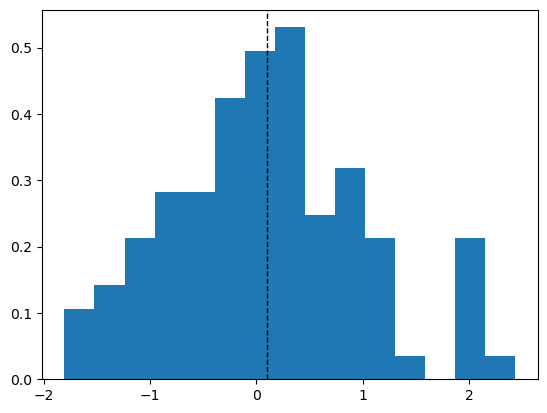

prior predictive check for theta ~ N(0.01, 0.25) has mean -0.029 and variance 0.183


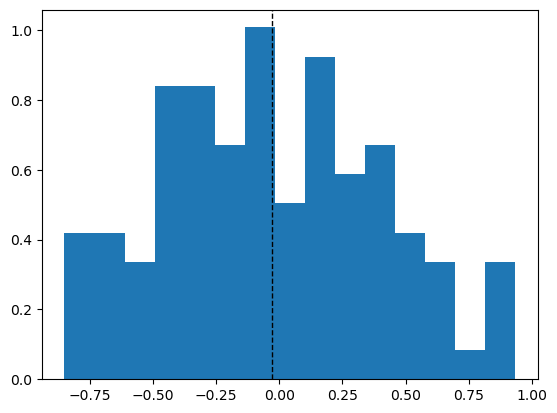

prior predictive check for theta ~ N(0.01, 1) has mean 0.140 and variance 1.166


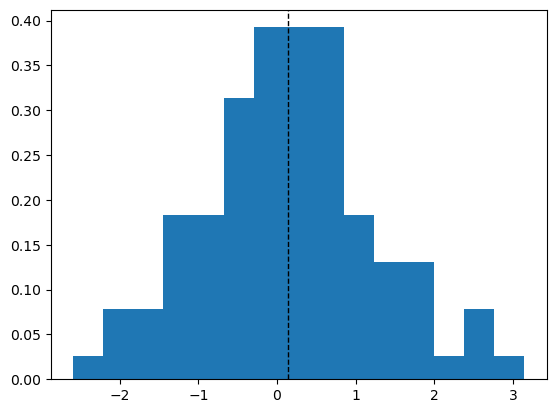

prior predictive check for theta ~ N(0.5, 0.028) has mean 0.503 and variance 0.026


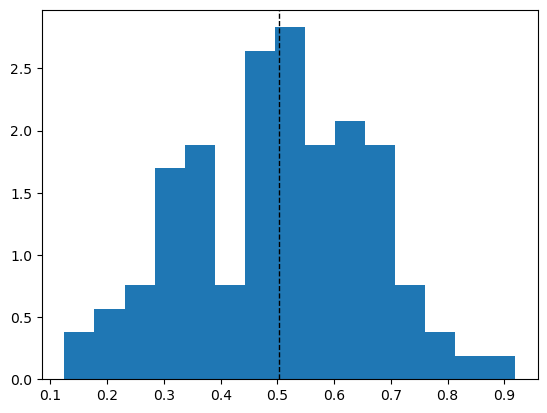

prior predictive check for theta ~ N(0.001, 0.028) has mean 0.024 and variance 0.026


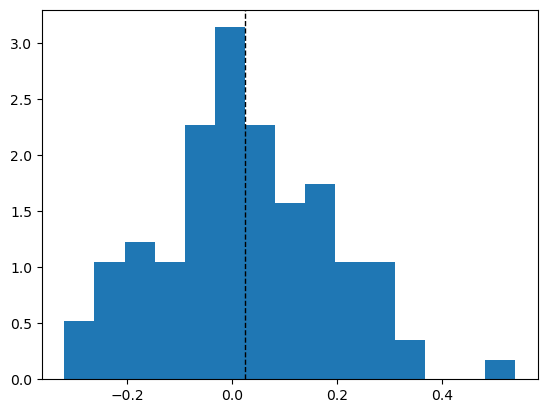

prior predictive check for theta ~ N(0.01, 0.028) has mean 0.047 and variance 0.027


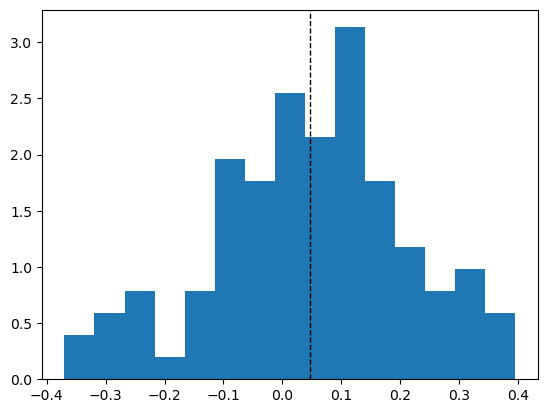

In [10]:
#this function takes as inputs: ab : the prior parameters, v: the variance of X, m:the number of data points
def predictive_check(ab, v, m):
    predictive_x = np.zeros(m)
    for j in range(m):
        theta_j = np.random.normal(ab[0], ab[1]**0.5, 1)
        predictive_x[j] = np.random.normal(theta_j, v**0.5, 1)
        
    return predictive_x

# plot all the different prior predictive checks
#the parameters we have chosen to test for:
prior_params = [(0.01, (1/36)), (0.01,(1/4)), 
(0.01, 1),
(0.5, (1/36)),
(0.001, (1/36)),
(0.01, (1/36))]
#a change in the variance for X
v = (np.mean(df['NORM_FLUX_ERR'])**2)*2     # sample variance
variance_ = [1, v, v, v, v, v] 
i = 0
for p in prior_params:
    x_pcheck = predictive_check(p, variance_[i], 100)
    i += 1
    plt.hist(x_pcheck, bins = 15, density = True)
    plt.axvline(x_pcheck.mean(), color='k', linestyle='dashed', linewidth=1)
    print(f'prior predictive check for theta ~ N({round(p[0],3)}, {round(p[1],3)}) has mean {x_pcheck.mean():.3f} and variance {x_pcheck.var():.3f}')
    plt.show()


We see that a prior like $N(0.5, \frac{1}{36})$ is very far from the marginal distribution that we have in mind.
The rest however, have a mean close to zero, and thus might be a good choice for the prior. Generally, our prior prediction models look fairly normal, so we can say our priors are reasonable given our assumptions.

##### 3.3 Posterior 
<a id='posterior'></a>

**Posterior**: Our posterior $q(\theta | x)$ is as follows:
$$
q(\theta | x) = \frac{p(x | \theta) \nu(x)}{p(x)}
        \propto exp \left\{ \frac{1}{2v}\sum_{i = 1}^{n}(x_i - \theta)^2 \right\} exp \left\{ -\frac{1}{2b}(\theta - a)^2 \right\}
$$

where $p(x | \theta)$ is the likelihood function, $p(x)$ is the marginal probability, $n$ is the number of repeated measures, 14, and $a$ and $b$ are as defined above.

Thus, our posterior mean is:
$$
\left(\frac{n}{v} + \frac{1}{b} \right)^{-1}\left(\frac{n\bar{x}}{v} + \frac{0.5}{b}\right) = \left(\frac{14}{v} + \frac{1}{1 / 36} \right)^{-1}\left(\frac{14\bar{x}}{v} + \frac{0.5}{1 / 36}\right)
$$
and our posterior variance is:
$$
\left(\frac{n}{v} + \frac{1}{b} \right)^{-1} = \left(\frac{14}{v} + \frac{1}{1 / 36} \right)^{-1}
$$
We plot our posterior parameters and distribution below.

Posterior mean:0.00541
Posterior variance: 0.000000323
Radius of TOI-564b: 0.77412 Rjup
Radius variance: 0.00304 Rjup
Confidence Region: (0.00429,0.00652)


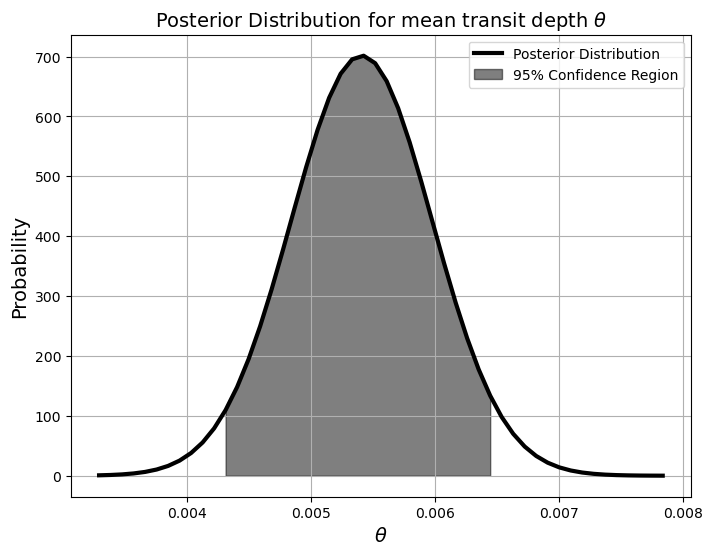

In [11]:
# setting our variables
ab = (0.01, (1/36))

# creating list to keep all posterior mean and credible regions
mean_cr_l = []

# calling function to plot distribution
fig, ax = plot_posterior_prob(tdf, mean_cr_l, params=ab, save=False, verbose=True);
ax.set_title(r'Posterior Distribution for mean transit depth $\theta$', size=14);
plt.show()

#### 3.4 Sensitivity Analysis
<a id='sensitivity'></a>

We will test to see how much the choice of prior changes the posterior mean and credibility region. We will test our chosen prior against 4 different priors, namely:
- $\nu(\theta) \sim N(0.01, \frac{1}{4})$
  
 We keep mean $a$ the same, but increase the variance $b$. This tests our assumption on the range of the transit depth of our exoplanet.

- $\nu(\theta) \sim N(0.01, 1)$

 We keep mean $a$ the same, but increase the vairance $b$ to be $1$. This is a very large value given our parameter space, and used to see what happens when we let the variance be very large.

- $\nu(\theta) \sim N(0.5, \frac{1}{36})$
 
 We change the mean to be greater, giving the exoplanet's transit depth larger possible values (meaning the exoplanet has a greater radius), and keep the variance the same. In this case, the chosen variance makes both zero and one 3 standard deviations away from the mean, giving any values outside of our parameter space a very low probability, which might be more desirable

- $\nu(\theta) \sim N(0.001, \frac{1}{36})$

 We change the mean to be smaller, and keep the variance the same.


Posterior mean:0.00541
Posterior variance: 0.000000323
Radius of TOI-564b: 0.77412 Rjup
Radius variance: 0.00304 Rjup
Confidence Region: (0.00429,0.00652)


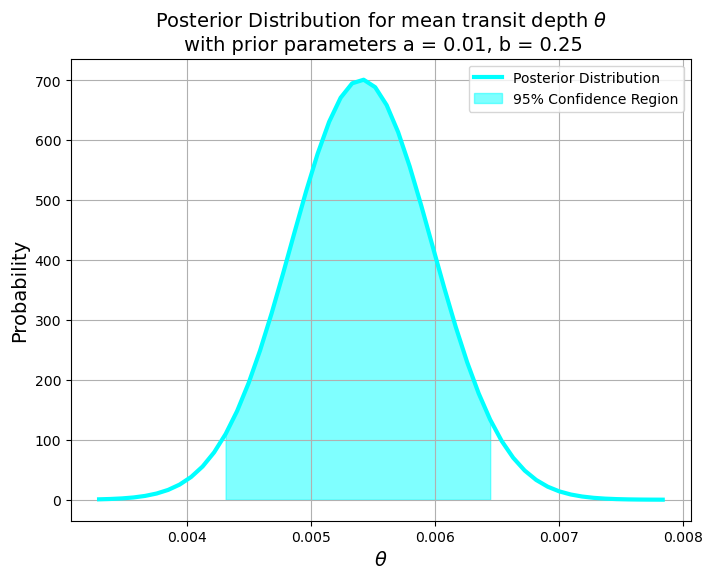


Posterior mean:0.00541
Posterior variance: 0.000000323
Radius of TOI-564b: 0.77412 Rjup
Radius variance: 0.00304 Rjup
Confidence Region: (0.00429,0.00652)


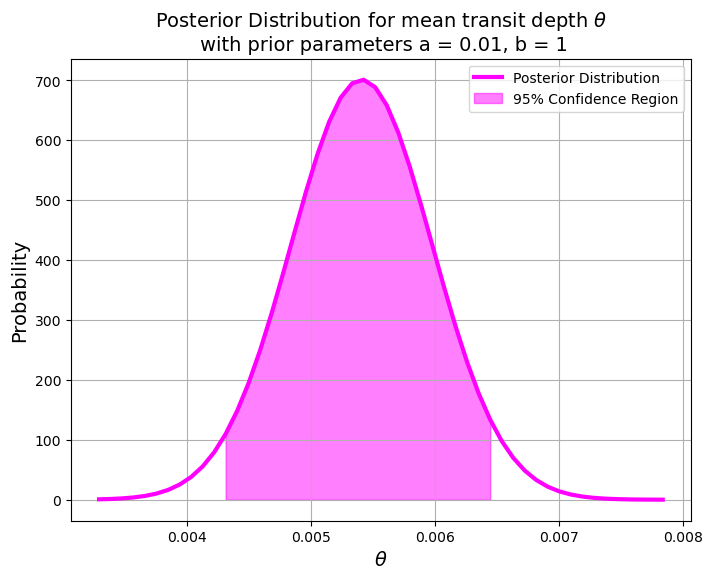


Posterior mean:0.00541
Posterior variance: 0.000000323
Radius of TOI-564b: 0.77412 Rjup
Radius variance: 0.00304 Rjup
Confidence Region: (0.00429,0.00652)


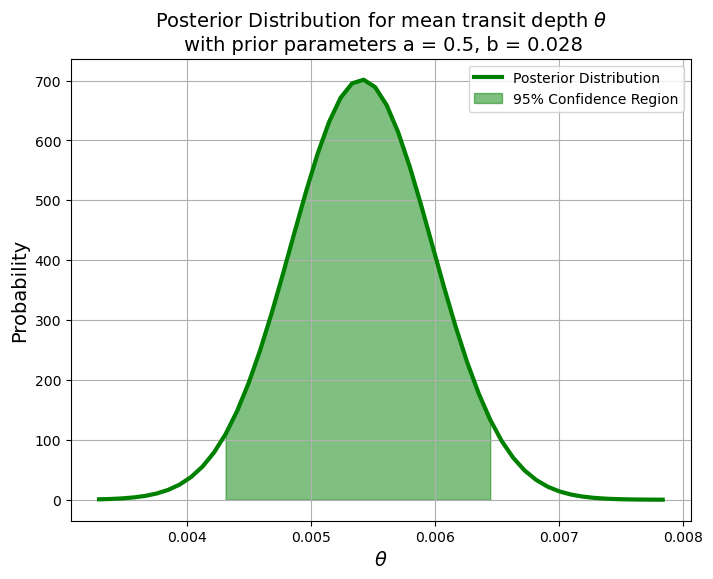


Posterior mean:0.00541
Posterior variance: 0.000000323
Radius of TOI-564b: 0.77412 Rjup
Radius variance: 0.00304 Rjup
Confidence Region: (0.00429,0.00652)


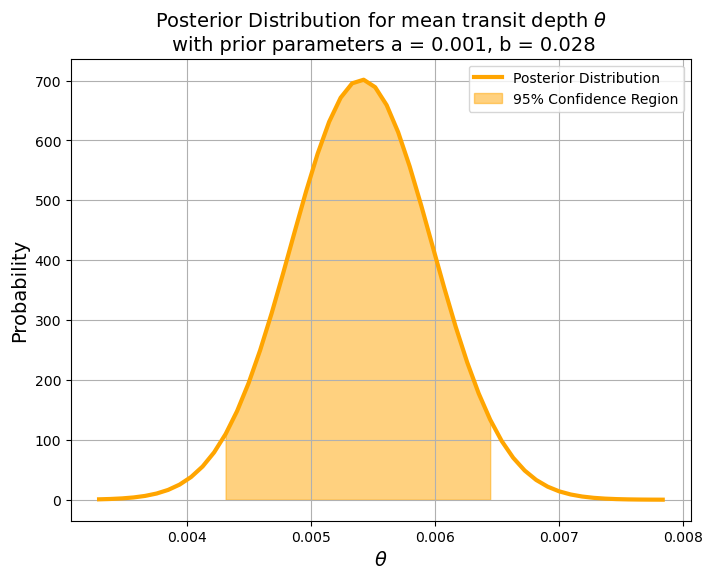

In [12]:
#setting the input values
v = (np.mean(df['NORM_FLUX_ERR'])**2)*2 #two points to get the transit depth so add error in quadrature to get the extra factor of 2 out front
n = len(tdf['Transit'])
xbar = np.mean(tdf['Depth'])

#posterior mean and variance array
params = [(0.01,(1/4)), 
(0.01, 1),
(0.5, (1/36)),
(0.001, (1/36))]

# (round(np.mean(tdf['Depth']),4),round(np.std(tdf['Depth']),4))


c = ['cyan', 
'magenta', 
'green',
'orange'
]


idx = 0
for ab in params:
    fig, ax = plot_posterior_prob(tdf, mean_cr_l, params=ab, c=c[idx], save=False);
    title = (r'Posterior Distribution for mean transit depth $\theta$' 
    '\n with prior parameters a = {}, b = {}'.format(round(ab[0],3), round(ab[1],3)));
    ax.set_title(title, size=14);
    plt.show()
    print()
    idx += 1

In [13]:
pd.set_option("display.precision", 10)
mean_cr_df = pd.DataFrame(mean_cr_l, columns=['a', 'b', 'Posterior Mean', 'Credible Region Lower Bound', 'CR Upper Bound'])

display(mean_cr_df)

,a,b,Posterior Mean,Credible Region Lower Bound,CR Upper Bound
0,0.010,0.0277777778,0.0054094286,0.0042949379,0.0065239193
1,0.010,0.2500000000,0.0054094845,0.0042949881,0.0065239810
2,0.010,1.0000000000,0.0054094898,0.0042949928,0.0065239868
3,0.500,0.0277777778,0.0054094286,0.0042949379,0.0065239193
4,0.001,0.0277777778,0.0054094286,0.0042949379,0.0065239193


As we can see, the posterior mean and credible regions for the different priors are extremely similar. This is probably due to our small sample size, as well as the very small range of our transit depth measurements, given that transit depth measurements are fairly precise (due to the very small errors of the measurements).

We do see that whenever the variance $b$ is $\frac{1}{36}$, our posterior mean is smaller than when $b$ is larger. However, this is in the 8th decimal place, which is much too small to take into account given our sample size.

Thus, we conclude that our posterior distribution is not sensitive to different priors.

### 4. Results
<a id='results'></a>

Using the mean transit depth of our posterior distribution, we find the transit depth of the exoplanet TOI-564b to be

$\theta = 54.1 \pm 0.2$ ppm, 

which corresponded to a radius of roughly $R_p = 0.77 \pm 0.06 \ R_j$. This is somewhat lower than the reported radius of the the exoplanet, which is $1.062_{-0.29}^{+0.71} \ R_j$. However, taking into account the uncertainty of this measurement, our estimates are within the reported uncertainty, albeit only just at the lower end.

We conclude that using the mean transit depth of an exoplanet to determine its radius is a good estimate.


The actual transit we observed represented, on average, less than half a percent of change compared to the mean flux of the star. This is a very small change, and it is not surprising that it is difficult to detect. However, the fact that we were able to detect it at all is a testament to the power of the TESS mission. In the past 20 years, the field of exoplanet detection has made great strides, and TESS is a major part of that. 